In [1]:
#import stuff
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.utils import shuffle
from datetime import timedelta
from tqdm import tqdm
from math import ceil

## Step 1: Dataset Exploration

In [2]:
# Load pickled data
training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']    

###basic data summary.
# TODO: number of training examples
n_train = X_train.shape[0]

# TODO: number of testing examples
n_test = X_test.shape[0]

# TODO: what's the shape of an image?
img_size = X_train.shape[1]
img_shape = (img_size,img_size)

#shape of a flat image
img_size_flat = img_size*img_size

# TODO: how many classes are in the dataset
n_cls = len(np.unique (y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", img_shape)
print("Image data size flat=", img_size_flat)
print("Number of classes =", n_cls)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Image data size flat= 1024
Number of classes = 43


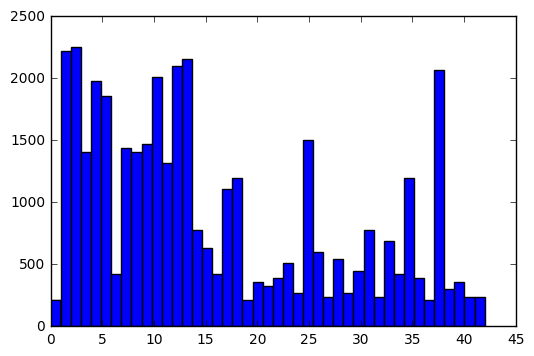

In [3]:
### Data exploration visualization goes here.
#histogram of the classes
plt.hist(y_train,bins=n_cls)  
plt.show()

## Step2: Preprocess & Data augmentation

In [4]:
#convert images to YUV, and only leave Y channel

X_train_YUV, X_test_YUV = np.zeros_like(X_train), np.zeros_like(X_test)
X_train_Y = np.zeros((n_train,X_train.shape[1],X_train.shape[2]))
X_test_Y = np.zeros((n_test,X_test.shape[1],X_test.shape[2]))

for i in range(n_train):
    X_train_YUV[i] = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2YUV)
    X_train_Y[i] = X_train_YUV[i][:,:,0]
    
for i in range(n_test):
    X_test_YUV[i] = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2YUV)
    X_test_Y[i] = X_test_YUV[i][:,:,0]

X_train = X_train_Y
X_test = X_test_Y
    
print (X_train.shape)
print (X_test.shape)

(39209, 32, 32)
(12630, 32, 32)


In [5]:
#helper function to jetter data

def transform_image(img,ang_range,trans_range,shear_range):
  
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])
    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2
    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

#generate additional training data
X_train_large = np.zeros((n_train*2,32,32))
y_train_large = np.zeros((n_train*2),dtype=np.int)

for i in range(n_train*2):
    y_train_large[i] = y_train[i%n_train]
    if i > (n_train-1):
        X_train_large[i] = transform_image(X_train[i%n_train],20,3,5)  
    else:
        X_train_large[i] = X_train[i]

n_train = n_train*2        
X_train = X_train_large
y_train = y_train_large  

print(X_train.shape)
print(y_train.shape)

(78418, 32, 32)
(78418,)


In [6]:
#flatten the images
X_train = np.reshape(X_train,(-1,img_size_flat))
X_test = np.reshape(X_test,(-1,img_size_flat))

#helper function to normalize the images
def normalize_greyscale(image_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (image_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )    

#normalize the images
normalize_greyscale(X_train)
normalize_greyscale(X_test)

#split the data into training/validation/testing sets.
X_train, X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=0.15)

#save the classes 
y_train_cls, y_validation_cls, y_test_cls = y_train, y_validation, y_test

#onehot encode labels
onehot_cls = []
for i in range (n_cls):
    onehot_cls.append(i)      
y_train = label_binarize(y_train, classes = onehot_cls)
y_validation = label_binarize(y_validation, classes = onehot_cls)
y_test = label_binarize(y_test, classes =onehot_cls)

print ('X_train shape:',X_train.shape)
print ('X_validation shape:',X_validation.shape)
print ('y_train shape:',y_train.shape)
print ('y_validation shape:',y_validation.shape)

X_train shape: (66655, 1024)
X_validation shape: (11763, 1024)
y_train shape: (66655, 43)
y_validation shape: (11763, 43)


In [7]:
# helper function for plotting traffic signs images,
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

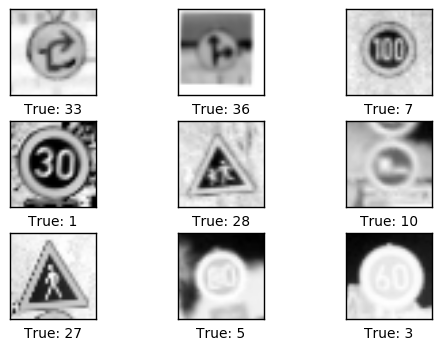

In [8]:
#plot ramdom images to check
X_train, y_train, y_train_cls = shuffle(X_train,y_train,y_train_cls)
plot_images(images=X_train[:9],cls_true=y_train_cls[:9])
plt.show()

## Step3: Model Architecture

### model structure

In [9]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

#Helper-function for creating a new Convolutional Layer
def new_conv_layer(input,              # The previous layer.
                   n_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   n_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, n_input_channels, n_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=n_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # 2x2 max-pooling
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    layer = tf.nn.relu(layer)

    # return both the resulting layer and the filter-weights
    return layer, weights

#Helper-function for flattening a layer
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The number of features is: img_height * img_width * num_channels
    n_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, n_features])

    # Return both the flattened layer and the number of features.
    return layer_flat, n_features

#Helper-function for creating a new Fully-Connected Layer
def new_fc_layer(input,          # The previous layer.
                 n_inputs,     # Num. inputs from prev. layer.
                 n_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[n_inputs, n_outputs])
    biases = new_biases(length=n_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    #dropouts
    layer = tf.nn.dropout(layer, keep_prob)    
        
    return layer

In [10]:
#Placeholder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_conv = tf.reshape(x, [-1, img_size, img_size, 1])

y = tf.placeholder(tf.float32, shape=[None, n_cls], name='y')
y_cls = tf.argmax(y, dimension=1)

keep_prob = tf.placeholder(tf.float32)

In [29]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
n_filters1 = 32         # There are 32 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
n_filters2 = 64         # There are 72 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [30]:
#Convolutional Layer 1
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_conv,
                   n_input_channels=1,
                   filter_size=filter_size1,
                   n_filters=n_filters1,
                   use_pooling=True)
    
#Convolutional Layer 2
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   n_input_channels=n_filters1,
                   filter_size=filter_size2,
                   n_filters=n_filters2,
                   use_pooling=True)    
    
#flatten layer
layer_flat, n_features = flatten_layer(layer_conv2)    
    
#Fully-Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         n_inputs=n_features,
                         n_outputs=fc_size,
                         use_relu=True)    
    
#fully-connected layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         n_inputs=fc_size,
                         n_outputs=n_cls,
                         use_relu=False)    
    
#Predicted Class
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)    


print('1st conv layer:')
print(layer_conv1)
print('2nd conv layer:')
print(layer_conv2)
print('flatten layer:')
print(layer_flat)
print('1st fully connected layer:')
print(layer_fc1)
print('2nd fully connected layer:')
print(layer_fc2)
    

1st conv layer:
Tensor("Relu_12:0", shape=(?, 16, 16, 32), dtype=float32)
2nd conv layer:
Tensor("Relu_13:0", shape=(?, 8, 8, 64), dtype=float32)
flatten layer:
Tensor("Reshape_14:0", shape=(?, 4096), dtype=float32)
1st fully connected layer:
Tensor("dropout_8/mul:0", shape=(?, 128), dtype=float32)
2nd fully connected layer:
Tensor("dropout_9/mul:0", shape=(?, 43), dtype=float32)


### Training

In [31]:
#Cost-function to be optimized
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2, labels=y)
loss = tf.reduce_mean(cross_entropy)

#Optimization Method
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)

#Performance Measures
correct_prediction = tf.equal(y_pred_cls, y_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [32]:
#parameter configurations
epochs = 100
batch_size = 500
learning_rate = 0.0001

Epoch 100/100: 100%|██████████| 134/134 [00:16<00:00,  8.29batches/s]


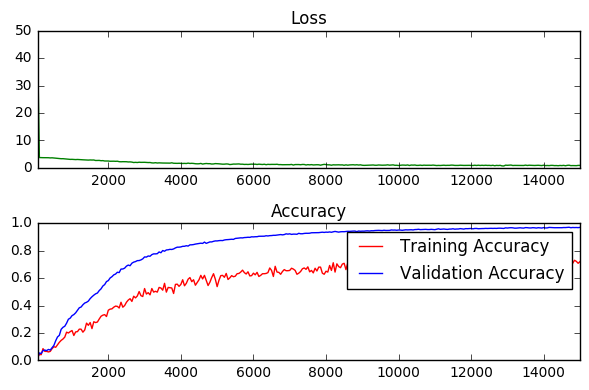

Validation accuracy at 0.969650387763977


In [33]:
# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

# The accuracy measured against the validation set
validation_accuracy = 0.0

session = tf.Session()
session.run(tf.initialize_all_variables())
batch_count = int(ceil(len(X_train)/batch_size))

for epoch_i in range(epochs):
    
    #shuffle the trainning data
    X_train, y_train = shuffle(X_train,y_train)
    
    # Progress bar
    batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
    # The training cycle
    for batch_i in batches_pbar:
        # Get a batch of training features and labels
        batch_start = batch_i*batch_size
        X_train_batch = X_train[batch_start:batch_start + batch_size]
        y_train_batch = y_train[batch_start:batch_start + batch_size]
        
        feed_dict_train = {x: X_train_batch, y: y_train_batch, keep_prob: 0.7}
              
        feed_dict_validation = {x: X_validation, y: y_validation, keep_prob: 1}

        # Run optimizer and get loss
        _, l = session.run(
            [optimizer, loss],
            feed_dict=feed_dict_train)

        # Log every 50 batches
        if not batch_i % log_batch_step:
            # Calculate Training accuracy and Validation accuracy
            training_accuracy = session.run(accuracy, feed_dict=feed_dict_train)
            validation_accuracy = session.run(accuracy, feed_dict=feed_dict_validation)

            # Log batches
            previous_batch = batches[-1] if batches else 0
            batches.append(log_batch_step + previous_batch)
            loss_batch.append(l)
            train_acc_batch.append(training_accuracy)
            valid_acc_batch.append(validation_accuracy)
            
    # Check accuracy against Validation data
    validation_accuracy = session.run(accuracy, feed_dict=feed_dict_validation)    
                
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=1)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

### Testing

In [34]:
#test result
feed_dict_test = {x: X_test, y: y_test, keep_prob:1}
cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
correct = (cls_pred == y_test_cls)
correct_sum = correct.sum()
acc = float(correct_sum) / n_test

# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, n_test))

Accuracy on Test-Set: 94.7% (11964 / 12630)


### Step 4: Test the Model on New Images

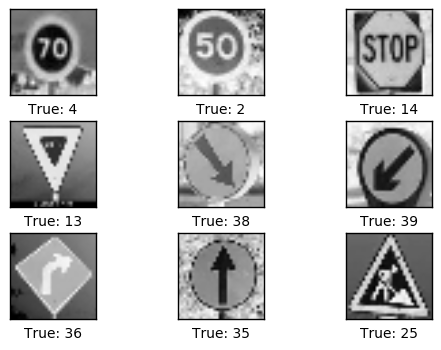

(9, 43)


In [35]:
#load images
img1,img2,img3 = cv2.imread('test-image/1.jpg'),cv2.imread('test-image/2.jpg'),cv2.imread('test-image/3.jpg')  
img4,img5,img6 = cv2.imread('test-image/4.jpg'),cv2.imread('test-image/5.jpg'),cv2.imread('test-image/6.jpg')  
img7,img8,img9 = cv2.imread('test-image/7.jpg'),cv2.imread('test-image/8.jpg'),cv2.imread('test-image/9.jpg')  

X_test2 = np.array((img1,img2,img3,img4,img5,img6,img7,img8,img9))

#convert images
X_test2_YUV = np.zeros_like(X_test2)
X_test2_Y = np.zeros((9,32,32))

#convert to YUV images, and leave only Y channel
for i in range(9):
    X_test2_YUV[i] = cv2.cvtColor(X_test2[i], cv2.COLOR_BGR2YUV)
    X_test2_Y[i] = X_test2_YUV[i][:,:,0]

#flatten the images    
X_test2_Y = np.reshape(X_test2_Y,(-1,1024))    
X_test2 = X_test2_Y

#normalize images
normalize_greyscale(X_test2)

#labels
y_test2_cls = [4,2,14,13,38,39,36,35,25]

#one-hot encode the labels  
y_test2 = label_binarize(y_test2_cls, classes = onehot_cls)

plot_images(images=X_test2, cls_true=y_test2_cls, cls_pred=None)
plt.show()
print(y_test2.shape)

In [36]:
#test result
feed_dict_test = {x: X_test2, y: y_test2, keep_prob:1}
cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
correct = (cls_pred == y_test2_cls)
correct_sum = correct.sum()
acc = float(correct_sum) / 9

# Print the accuracy.
msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
print(msg.format(acc, correct_sum, 9))

Accuracy on Test-Set: 77.8% (7 / 9)


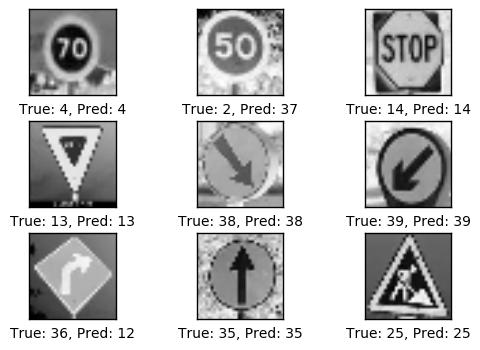

In [37]:
#plot the images and predictions
plot_images(images=X_test2, cls_true=y_test2_cls, cls_pred=cls_pred)
plt.show()

In [38]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
sm = session.run(y_pred,feed_dict=feed_dict_test)
res = np.zeros((9,5),dtype=int)
for i in range(9):
    certainty = np.amax(sm[i])
    res[i] = np.argsort(sm[i])[::-1][:5]
    msg = "prediction certainty: {0:.1%}"
    print('image',i+1,msg.format(certainty))
    print('top 5 predictions:',res[i],' true class:',y_test2_cls[i])
    print()

image 1 prediction certainty: 100.0%
top 5 predictions: [ 4 15  8  2 14]  true class: 4

image 2 prediction certainty: 51.2%
top 5 predictions: [37  2  4 13  1]  true class: 2

image 3 prediction certainty: 100.0%
top 5 predictions: [14 39  1  2 32]  true class: 14

image 4 prediction certainty: 100.0%
top 5 predictions: [13 11 40  2 38]  true class: 13

image 5 prediction certainty: 100.0%
top 5 predictions: [38 34 13  1 21]  true class: 38

image 6 prediction certainty: 100.0%
top 5 predictions: [39 32 37 38 25]  true class: 39

image 7 prediction certainty: 98.0%
top 5 predictions: [12 35 14 33 37]  true class: 36

image 8 prediction certainty: 100.0%
top 5 predictions: [35 37 33 25 13]  true class: 35

image 9 prediction certainty: 100.0%
top 5 predictions: [25 29 21 22 11]  true class: 25



In [39]:
session.close()